### Vi prøver igen ...

- Alle data i en fil, vi korter i koden
- vi prøver med texts_to_matrix
- Jeg kan selv vælge hvad der er stort (kan prøve andet end 10), måske kan den lettere finde f.eks. 5?

### Konklusion
- Det er lykkedes at få det til at virke med een datafil, som indeholder både train og test
- Det er lykkedes at lave en opdeling på et vilkåligt tal i kode for stor og lille
- Data - som de er nu - har ikke ret megen struktur, det var også det jeg egentligt gættede på fra start. De rigtigt store kan modellen godt genkende, men rigtigt mange smutter bare igennem

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')


In [2]:
# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FEDAll.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
StorEr = 3
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values
labels = np.asarray([1*(NumLines[i]>=StorEr) for i in range(len(NumLines))])

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
labels = labels[indices]

# opdeling i training data og test data
i = 90000  # antal linjer afsat til træning, resten er test
texts_train  = texts[:i]
texts_test   = texts[i:] 
labels_train = labels[:i]
labels_test  = labels[i:]

In [3]:
# laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# sætninger laves om til en "one hot" data vektor
# tester ...
data_train = tokenizer.texts_to_matrix(texts_train, mode='binary')
data_test  = tokenizer.texts_to_matrix(texts_test,  mode='binary')

# labels laves til vektor
labels_train = np.asarray(labels_train).astype('float32')
labels_test = np.asarray(labels_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(90000, 10000)
(10867, 10000)
(90000,)
(10867,)


In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [6]:
NumEpochs = 10
history = model.fit(data_train, labels_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.1)

Train on 81000 samples, validate on 9000 samples
Epoch 1/10
81000/81000 [==============================] - 18s 219us/step - loss: 0.6417 - acc: 0.6438 - val_loss: 0.6188 - val_acc: 0.6681
Epoch 2/10
81000/81000 [==============================] - 15s 188us/step - loss: 0.6065 - acc: 0.6824 - val_loss: 0.6091 - val_acc: 0.6761
Epoch 3/10
81000/81000 [==============================] - 15s 185us/step - loss: 0.5930 - acc: 0.6925 - val_loss: 0.6068 - val_acc: 0.6766
Epoch 4/10
81000/81000 [==============================] - 14s 167us/step - loss: 0.5830 - acc: 0.7017 - val_loss: 0.6078 - val_acc: 0.6777
Epoch 5/10
81000/81000 [==============================] - 14s 172us/step - loss: 0.5735 - acc: 0.7086 - val_loss: 0.6081 - val_acc: 0.6728
Epoch 6/10
81000/81000 [==============================] - 12s 149us/step - loss: 0.5655 - acc: 0.7157 - val_loss: 0.6117 - val_acc: 0.6774
Epoch 7/10
81000/81000 [==============================] - 16s 200us/step - loss: 0.5594 - acc: 0.7203 - val_loss: 0.6

In [7]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [8]:
import matplotlib.pyplot as plt
plt.show()

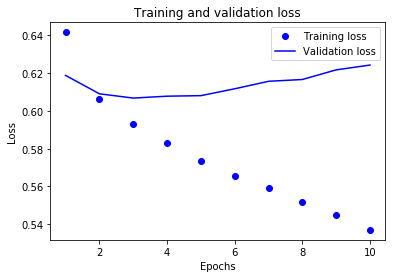

In [9]:
# plotter historikken for 'loss' og 'accuracy'
accu = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # "bo" is for "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b is for "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

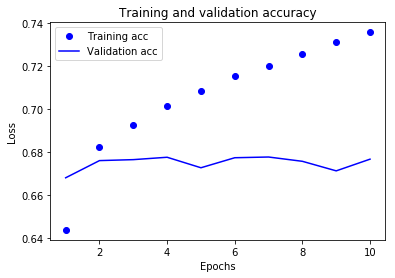

In [10]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [11]:
# vi prøver modellen på test-data

predictions = model.predict(data_test)

for i in range(1,10):
    print(('%1.4f' % predictions[i]))

0.3951
0.2697
0.2482
0.2931
0.4186
0.6593
0.9628
0.3951
0.4322


In [12]:
# finder ud af hvor stor en del store, som er fundet

print('Antal store i datasættet:    ', sum(labels_test))
NumEstimated = 0
for i in range(1,6000):
    if predictions[i]>0.4 and labels_test[i]:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)
print('Modellens præcision:         ', round(NumEstimated/sum(labels_test)*100), '%')

Antal store i datasættet:     4024.0
antal estimeret af modellen:  1240
Modellens præcision:          31.0 %


In [13]:
# Gennemsnittet for rigtig og forkert

print(' Gennemsnit for test stor og lille')
print(np.average([x for i, x in enumerate(predictions) if labels_test[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels_test[i]]))

 Gennemsnit for test stor og lille
0.46104845
0.3223823


In [14]:
# jeg prøver at printe linjenummer, prediction og tekststreng for dem som er store = "rigtige"

print('Jeg printer nogle liner som er sande i test data:')
for i in range(1,300):
    if labels_test[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

Jeg printer nogle liner som er sande i test data:
   1  0.3951  Materielfejl
   2  0.2697  Kom ikke med i 145
   3  0.2482  mgl icu sæt.
   5  0.4186  Materielfejl... Gearfejl efter kobling.. K -27 u Es..
   6  0.6593  K -15 u Pe.. Brandalarm.. Lok efterset, og intet unormalt fundet..
   7  0.9628  K -9 i Hv.. Fejl på ovk 105, 107 og 110 mellem Hv og Tø..
  13  0.2790  2 ICA på Kh
  15  0.5311  Materielfejl MG : holder ud foran kalvebod tunnelen og har kun 25 % trækkraft
  16  0.3321  har nu kun en motor der virker bliver holdene i NF til i morgen pga for høj kølevandstemperatur
  17  0.5908  Kører med 2xMF fra Fa... Som følge af omslagene pga sporskiftet i Ka.. (Desværre er der ikke brænd
  19  0.9096  Der er fejl på overkørsel 23 ved Højby.
  21  0.5842  Materielmangel, ER og ET
  25  0.4123  Manglende togsæt i Kh og Fa
  26  0.1451  mgl behov
  29  0.6712  Materielfejl, trækker lysbue ved Kokkedal
  32  0.4847  Personaleforhold: Sygemelding på LKF-siden der ikke kan dækkes
  33  0.6

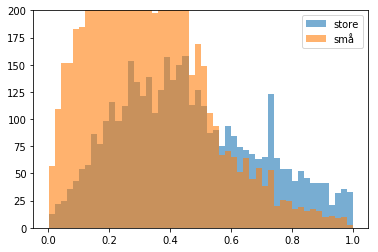

In [15]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels_test[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels_test[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=0.6, label='store')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små')
plt.legend(loc='upper right')
plt.ylim([0, 200])

plt.show()

UHA UHA, alt for mange af de sande har en værdi tæt på 0 ...

### Modellen er ikke specielt præcis. jeg checker lige efter på træninsdata, dem kan man håbe den har lært bedre at kende???

In [16]:
# vi prøver modellen på test-data

predictions = model.predict(data_train)

# print de første predictions
for i in range(1,10):
    print(('%1.4f' % predictions[i]))

0.3805
0.3394
0.0786
0.1136
0.1722
0.2866
0.1254
0.3175
0.0702


In [17]:
# finder ud af hvor stor en del store, som er fundet

print('Antal store i datasættet:    ', sum(labels_train))
NumEstimated = 0
for i in range(1,len(labels_train)):
    if predictions[i]>0.4 and labels_train[i]:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)
print('Modellens præcision:         ', round(NumEstimated/sum(labels_train)*100), '%')

Antal store i datasættet:     33395.0
antal estimeret af modellen:  22299
Modellens præcision:          67.0 %


In [18]:
# jeg prøver at printe linjenummer, prediction og tekststreng, som er RIGTIGE (store)

print('Nogle linjer som er SANDE i train data:')
for i in range(1,300):
    if labels_train[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

Nogle linjer som er SANDE i train data:
   7  0.1254  Afkobler forreste sæt (ET 4320) på KH og køres på drejebænken
   8  0.3175  Har gul motoralarm
  14  0.4369  der mangler  mq
  18  0.7925  ID: 07:28  Sporskiftefejl i Helsingør
  21  0.8106  Ny udvikling i sagen med DB og Scandlines. Nu forventes 33 forsinket to timer i ankomst til Danmark.
  24  0.4092  Nedbrudt Kh.. Dørfejl.. Lki-vagten kan ikke hjælpe den i gang :-(
  25  0.4757  Disponering DSB/BDK for at køre blokken i orden mellem Nf-Rf
  26  0.2758  Disponering materiel
  27  0.3580  Personalforhold, mangler en Lkf i Helsingør til 2028.
  30  0.2756  Kan ikke kører til Flb
  32  0.4332  Materielfejl: ingen virksom dansk ATC
  33  0.4284  BDK ØVRIGE
  39  0.8187  Aflysninger pga. mgl materiel
  40  0.6634  Disponering DSB : Der mgl en ER på KK og VK forventer ikke noget klar fra VK
  42  0.8061  Har påkørt en tabt puffer fra et G tog på vej ud af RG .
  46  0.3803  Holder ikke i Fh
  47  0.2110  Materielfejl. Vendegearsfejl.
 

In [19]:
# jeg prøver at printe linjenummer, prediction og tekststreng, som er FORKERTE (små)

print('Nogle linjer som er FALSKE i train data:')
for i in range(1,200):
    if labels[i]==0:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

Nogle linjer som er FALSKE i train data:
   1  0.3805  Problemer med TC, Lki er på sagen. Forventet minus 10 min.
   2  0.3394  Disponering
   3  0.0786  Materielfejl. Der løber olie ud fra en utæt slange, med røgudvikling til følge. Sættes til side på p
   4  0.1136  Ændring Ar:
   5  0.1722  medgives ER 2015 til Fa
   6  0.2866  Materielfejl: Koldt førerrum.
   9  0.0702  Kan ikke lave gennemgang 2+3F
  10  0.3286  Materielmgl. ET. HG.
  11  0.3555  Radioen virker ikke, kører og Vigerslev og vender
  12  0.4274  Må IKKE køre i Tyskland
  13  0.0245  Hjælpevogn Øst har frigivet ME 1512 til drift indtil Kh. Vi kobler den på RØ 4270. Ventilationsrist 
  15  0.2740  OPFOREMERING
  16  0.3906  Fa. Der kan ikke leveres 2 MQ til dette udvekslingstog. Pt står der syv togsæt til rep. i Fa.
  17  0.3666  Kommer forsinket til Kh
  19  0.1783  Defekte koblinger, udskiftes i Ar
  20  0.3398  Der mangler mat på Hgl
  22  0.1787  DSB/DB disponering. DB medgiver IE 33 en ekstra BR til Puttgarden. Pl

In [20]:
# finder gennemsnittet for dem som er rigtige og forkerte

print(' Gennemsnit for ttrain stor og lille')
print(np.average([x for i, x in enumerate(predictions) if labels[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels[i]]))

 Gennemsnit for ttrain stor og lille
0.51668894
0.2858782


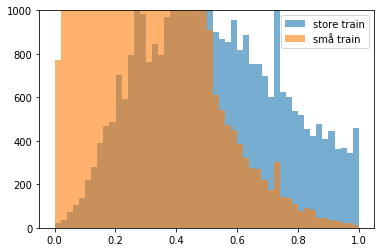

In [21]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels_train[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels_train[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=0.6, label='store train')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små train')
plt.legend(loc='upper right')
plt.ylim([0, 1000])

plt.show()